In [1]:
import pandas as pd
import joblib
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/res_purchase_card_fiscal_year_2014_3pcd-aiuu.csv')
data.head(5)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


### Feature Extraction

With the given data, the following features can be extracted:
1) Weekday on which the transaction took place

2) Month in which this transaction took place

3) Time interval(K) in between transactions for each cardholder

4) There are some transactions where the transaction consist of negative amount that we came across in EDA , this indicates a refund. These can be used as our labels.

In [3]:
df = data.copy()


df["name"] = df["Cardholder First Initial"].astype(str).str.cat(df["Cardholder Last Name"].astype(str), sep="_")
df = df[["name", "Transaction Date", "Amount"]]
df.columns = ["name", "transaction_date", "amount_spend"]
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["k_interval"] = df.sort_values(["name", "transaction_date"]).groupby("name")["transaction_date"].diff().dt.days
df.dropna(subset=["k_interval"], inplace=True)

df["y_label"] = df["amount_spend"].map(lambda x: 1 if x >0 else 0)


name_cat_code_map = dict( zip( df['name'], df['name'].astype('category').cat.codes ) )



df["encd_name"] = df.name.map(lambda x: name_cat_code_map.get(x))
df

,name,transaction_date,amount_spend,k_interval,y_label,encd_name
0,C_Mason,2013-07-30,890.00,3.0,1,815
1,C_Mason,2013-07-30,368.96,0.0,1,815
2,J_Massey,2013-07-29,165.82,4.0,1,2192
3,T_Massey,2013-07-30,96.39,6.0,1,4722
4,M_Mauro-Herrera,2013-07-30,125.96,1.0,1,3335
...,...,...,...,...,...,...
442453,e_Cardholder,2014-06-20,992.00,0.0,1,5032
442454,e_Cardholder,2014-06-20,2415.00,0.0,1,5032
442455,e_Cardholder,2014-06-20,177.50,0.0,1,5032
442456,e_Cardholder,2014-06-19,32457.00,0.0,1,5032


In [4]:
df.columns

Index(['name', 'transaction_date', 'amount_spend', 'k_interval', 'y_label',
       'encd_name'],
      dtype='object')

In [5]:
cols = ['encd_name','transaction_date', 'k_interval', 'y_label']
df = df[cols]
df["date"] = df["transaction_date"]
df

C:\Users\sohai\miniconda3\envs\one_by_zero_submission_2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,encd_name,transaction_date,k_interval,y_label,date
0,815,2013-07-30,3.0,1,2013-07-30
1,815,2013-07-30,0.0,1,2013-07-30
2,2192,2013-07-29,4.0,1,2013-07-29
3,4722,2013-07-30,6.0,1,2013-07-30
4,3335,2013-07-30,1.0,1,2013-07-30
...,...,...,...,...,...
442453,5032,2014-06-20,0.0,1,2014-06-20
442454,5032,2014-06-20,0.0,1,2014-06-20
442455,5032,2014-06-20,0.0,1,2014-06-20
442456,5032,2014-06-19,0.0,1,2014-06-19


In [6]:
!pip install tqdm

In [7]:
# Define function to generate rows based on k_interval
from tqdm import tqdm

def generate_previous_rows(df):
    rows = []
    for _, row in tqdm(df.iterrows()):
        start_date = row['date'] - pd.DateOffset(days=row['k_interval'])
        end_date = row['date']
        dates = pd.date_range(start_date, end_date)
        for date in dates:
            if date !=end_date:
                new_row = row.copy()
                new_row['date'] = date
                new_row["y_label"] = 0
                rows.append(new_row)
            else:
                rows.append(row)
    return pd.DataFrame(rows)

# Generate rows based on k_interval
generated_data = generate_previous_rows(df)
print(generated_data)


437245it [02:51, 2549.21it/s]


        encd_name transaction_date  k_interval  y_label       date
0             815       2013-07-30         3.0        0 2013-07-27
0             815       2013-07-30         3.0        0 2013-07-28
0             815       2013-07-30         3.0        0 2013-07-29
0             815       2013-07-30         3.0        1 2013-07-30
1             815       2013-07-30         0.0        1 2013-07-30
...           ...              ...         ...      ...        ...
442453       5032       2014-06-20         0.0        1 2014-06-20
442454       5032       2014-06-20         0.0        1 2014-06-20
442455       5032       2014-06-20         0.0        1 2014-06-20
442456       5032       2014-06-19         0.0        1 2014-06-19
442457       5032       2014-06-20         0.0        1 2014-06-20

[1810895 rows x 5 columns]


In [8]:
feature_data = generated_data[["encd_name", "date", "k_interval", "y_label"]]
feature_data["month"] = feature_data["date"].dt.month
feature_data["weekday"] = feature_data["date"].dt.weekday


feature_data = feature_data[["encd_name", "month", "weekday","k_interval", "y_label"]]
feature_data

,encd_name,month,weekday,k_interval,y_label
0,815,7,5,3.0,0
0,815,7,6,3.0,0
0,815,7,0,3.0,0
0,815,7,1,3.0,1
1,815,7,1,0.0,1
...,...,...,...,...,...
442453,5032,6,4,0.0,1
442454,5032,6,4,0.0,1
442455,5032,6,4,0.0,1
442456,5032,6,3,0.0,1


<AxesSubplot:>

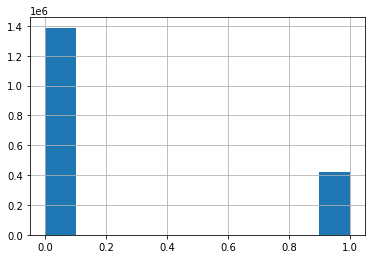

In [9]:
feature_data["y_label"].hist()

In [19]:
X = feature_data[["encd_name", "month", "weekday","k_interval"]]
Y = feature_data["y_label"]
corr = feature_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,encd_name,month,weekday
encd_name,1.000000,0.001774,0.004304
month,0.001774,1.000000,-0.003550
weekday,0.004304,-0.003550,1.000000


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
# Define and train the XGBoostClassifier model
model = XGBClassifier()
model.fit(X_train, y_train)



C:\Users\sohai\miniconda3\envs\one_by_zero_submission_2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### For Train Dataset

In [13]:
y_pred = model.predict(X_train)
print(f"ROC_AUC_SCORE: {roc_auc_score(y_train,y_pred)}")
print(f"Classification Report: {classification_report(y_train, y_pred, output_dict=True)}")

ROC_AUC_SCORE: 0.7958551706100808
Classification Report: {'0': {'precision': 0.8941603136335909, 'recall': 0.9676432790617461, 'f1-score': 0.9294516578289491, 'support': 1110403}, '1': {'precision': 0.8545731991143816, 'recall': 0.6240670621584155, 'f1-score': 0.7213532591241125, 'support': 338313}, 'accuracy': 0.8874092644797186, 'macro avg': {'precision': 0.8743667563739863, 'recall': 0.7958551706100807, 'f1-score': 0.8254024584765308, 'support': 1448716}, 'weighted avg': {'precision': 0.8849156891010136, 'recall': 0.8874092644797186, 'f1-score': 0.8808552500022742, 'support': 1448716}}


### For Test Dataset

In [14]:
y_pred = model.predict(X_test)
print(f"ROC_AUC_SCORE: {roc_auc_score(y_test,y_pred)}")
print(f"Classification Report: {classification_report(y_test, y_pred, output_dict=True)}")

ROC_AUC_SCORE: 0.7954142966760188
Classification Report: {'0': {'precision': 0.8940632397644074, 'recall': 0.9671948105273395, 'f1-score': 0.9291923015702748, 'support': 277639}, '1': {'precision': 0.8526928675400292, 'recall': 0.6236337828246984, 'f1-score': 0.7203935232629638, 'support': 84540}, 'accuracy': 0.887000626761905, 'macro avg': {'precision': 0.8733780536522182, 'recall': 0.7954142966760189, 'f1-score': 0.8247929124166193, 'support': 362179}, 'weighted avg': {'precision': 0.8844065471680698, 'recall': 0.887000626761905, 'f1-score': 0.8804543882232831, 'support': 362179}}


In [15]:
X_train.iloc[0]

encd_name     3305.0
month            9.0
weekday          0.0
k_interval      20.0
Name: 32973, dtype: float64

## Saving Model Using Joblib along with Name:Category_code mapping

In [17]:
joblib.dump(model, "../models/classification_model.pkl")
_ = joblib.load( "../models/classification_model.pkl")

import json

with open("../models/classification_model_name_codes.json", 'w') as fp: 
     fp.write(json.dumps(name_cat_code_map))

with open("../models/classification_model_name_codes.json", "r") as f:
    _ = json.load(f)

In [22]:
import datetime
datetime.datetime.today().month

3

## To be added to the model service

In [73]:
import datetime
# Input

name = "C_Mason"
k = 5
name_codes_map=None
xgboost_classifier=joblib.load( "../models/classification_model.pkl")


with open("../models/classification_model_name_codes.json", "r") as f:
    name_codes_map = json.load(f)

# def generate_rows(df):
#     rows = []
#     for _, row in df.iterrows():
#         start_date = row['date']
#         end_date = start_date + pd.DateOffset(days=row['k_interval'])
#         dates = pd.date_range(start_date, end_date)
#         for date in dates:
#             new_row = row.copy()
#             new_row['date'] = date
#             rows.append(new_row)
#     return pd.DataFrame(rows)

df = pd.DataFrame({
        "encd_name": name_cat_code_map[name],
        "month": datetime.datetime.today().month,
        "weekday": datetime.datetime.today().weekday(),
        "k_interval": k
    },index=[0]).astype('float64')
xgboost_classifier.predict(df)[0]

0

In [76]:
df["encd_name"].iloc[0]

815.0